In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
from scipy import special as ssp # fonction gamma
%matplotlib inline

# Importation des données

In [77]:
seuil_detection_fitness=0.005

data = "cleaned"    # "raw" data or "cleaned" data (without dead cells and aberrant growth rates)

if data == "raw":
    file="Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",", 
                          usecols=range(2,1476*3+1,3), 
                          skiprows=[1,2])

elif data == "cleaned":
    file="Donnees_article_modifiees/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",")

growthR_real = growthR_real.to_numpy()
growthR_real[growthR_real<seuil_detection_fitness] = 0

In [78]:
with open('Donnees_simulees/growthR_sim.npy', 'rb') as f:
    growthR_sim = np.load(f)
with open('Donnees_simulees/growthR_sim_noisy.npy', 'rb') as f:
    growthR_sim_noise = np.load(f)

## Rappel de la densité de la DFE des simulations :

# Calcul de Ff

In [79]:
def fourier_inverse_old(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/(n*2*np.pi)]
    return (xi[1]-xi[0])*np.array(res)#/(2*np.pi)


def fourier_inverse0(X,Xi,F_Xi):
    print([[np.mean(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi)] for x in X])
    return [np.mean(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def fourier_inverse(X,Xi,F_Xi):
    print(Xi[1]-Xi[0])
    print(np.sum(np.array(F_Xi)*np.exp(1j*x*Xi)))
    return [(Xi[1]-Xi[0])*np.sum(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def get_fourier_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*Wt[Wt>0])) for xi in Xi]

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [80]:
def get_axi(wt,ximin,ximax,nbreaks_xi,tmax):
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot_four = ([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    tot_abs = np.log(np.abs(tot_four))
    tot_ang = np.angle(tot_four)
        
    # régression linéaire:
    res=[]
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot_abs)[:,k])
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(range(tmax),np.real(tot_ang)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        res+=[(Xi[k],slope,slope2)]
        #print("pente :",slope, "\tpente angle :",slope2)
    # affichage:
    #plt.plot(range(tmax),tot_abs)
    #plt.grid()
    #plt.legend(["xi="+str(xi) for xi in Xi])
    #plt.xlabel("t")
    #plt.ylabel("ln[Fu_t(xi)]")
    #plt.title(titre)
    #plt.show() 
    return res

# Calcul effectif de la DFE

In [81]:
xmin_reel=-0.1
xmax_reel=0.999
nbreaks_x=100
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(1-x)

x2min_reel=-10
x2max_reel=0.999
nbreaks_x2=100
x2=np.linspace(x2min_reel,x2max_reel,nbreaks_x2)
lnx2=np.log(1-x2)

In [82]:
lambd=0.32/60 # constante biologique = taux de mutation

<ipython-input-83-e0de9543d480>:4: RuntimeWarning: invalid value encountered in double_scalars
  dfe_reelle_sim=[(z>0)*z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in x]


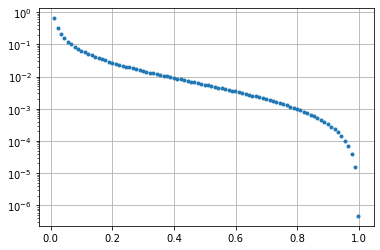

In [83]:
alpha=0.0074
beta=2.4

dfe_reelle_sim=[(z>0)*z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in x]
plt.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,'.')

La fonction suivante applique la formule de la dfe trouvée avec l'edp :

In [84]:
def get_dfe(wt,ximin,ximax,nbreaks_xi):
    a_xi=[]
    xi=[]
    xi_axi=get_axi(wt,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    y=fourier_inverse_old(lnx,xi,Ff)
    return y

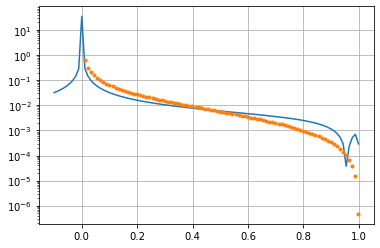

In [136]:
dfeln=get_dfe(growthR_sim,ximin=0,ximax=2,nbreaks_xi=100)

# on transforme f densité de ln(1-s) en g densité de 1-s:
# g(z)=f(ln z)/z
dfe=[dfeln[i]/x[i] for i in range(len(x))]
plt.yscale('log')
plt.grid()
plt.plot(x,np.abs(dfe))
plt.plot(x,dfe_reelle_sim,'.')
plt.show()

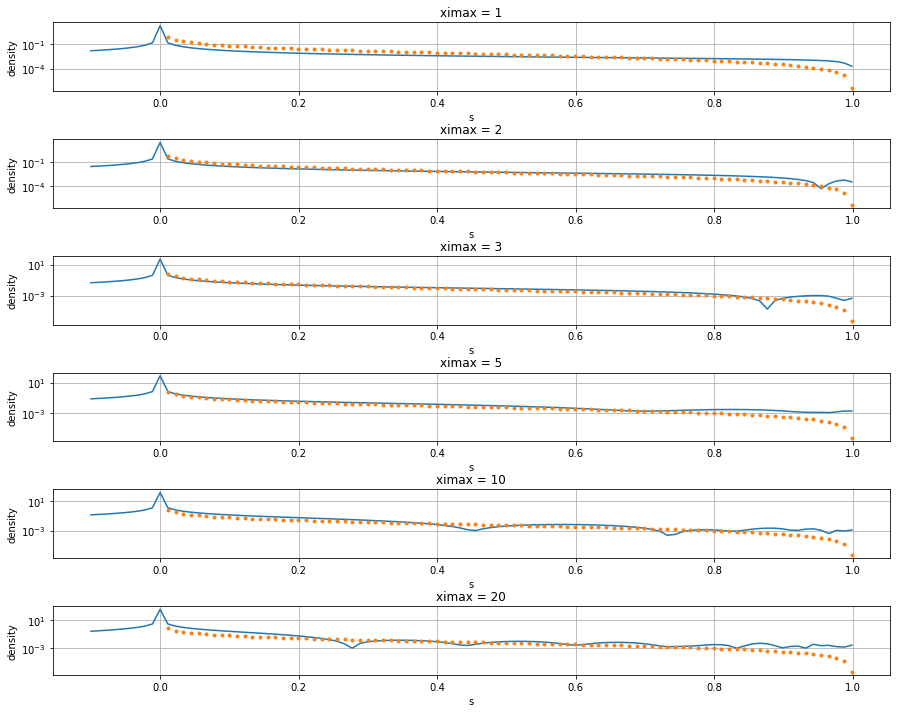

In [135]:
fig, ax = plt.subplots(6,1, figsize=(15,12))
fig.subplots_adjust(hspace=0.7)
dfeln=[]
dfe=[]
for i,ximax in enumerate([1,2,3,5,10,20]):
    dfeln+=[get_dfe(growthR_sim_noise,ximin=0,ximax=ximax,nbreaks_xi=100)]
    dfe+=[[dfeln[i][j]/x[j] for j in range(len(x))]]
    ax[i].plot(x,np.abs(dfe[i]))
    ax[i].plot(x,dfe_reelle_sim,'.')
    ax[i].grid()
    ax[i].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

$\to$ avec $\xi_{max}=2$, on n'est pas mauvais ! (est-ce seulement de la chance ?)

Un peu louche : on retrouve presque la même chose avec les données réelles qu'avec les données simulées... (mais pas tout à fait si ximax=10 par exemple)

Tracer im(dfe) au lieu de re(dfe): on trouve presque 0 : c'est ce à quoi on s'attendait !

# Vérification



```
def get_mom(x,dist,k):
    dx=(x[len(x)-1]-x[0])/len(x)
    return dx*np.mean([x[i]**k*dist[i] for i in range(1,len(x))])
```

```
m=[0]*10
for k in range(len(m)):
    for i in range(6):
        m[i]=get_mom(x,dfe[i],k)
        print("ordre",k,":",np.abs(m[i]))
    print("")
```

## DFE sur un plus grand domaine

```
xmin_reel=-5
xmax_reel=0.99
nbreaks_x=100
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(np.array([1-xp for xp in x]))

dfeln=get_dfe(growthR_sim,ximin=0,ximax=2,nbreaks_xi=100)

# on transforme f densité de ln(1-s) en g densité de 1-s:
# g(z)=f(ln z)/z
dfe=[dfeln[i]/x[i] for i in range(len(x))]
plt.grid()
plt.title("ximax=2")
plt.plot(x,np.real(dfe))
plt.show()
```

# Réplications sur différentes simulations

- Distribution initiale des taux de croissances

In [87]:
data = "raw"    # "raw" data or "cleaned" data (without dead cells and aberrant growth rates)

if data == "raw":
    file="Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",", 
                          usecols=range(2,1476*3+1,3), 
                          skiprows=[1,2])

elif data == "cleaned":
    file="Donnees_article_modifiees/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",")

growthR_real = growthR_real.to_numpy()


In [88]:
growthR_init = np.array([np.median([l for l in d if not np.isnan(l)]) for d in growthR_real.T[:,:10]])   # médiane des 10 premières mesures
growthR_init[growthR_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante
np.mean(growthR_init)

0.02970835419342819

- Paramètres utilisés pour la simulation

In [89]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = 4000       # durée de l'expérience, en minutes
mut_shape = (int(exp_duration*mutation_rate*5), len(growthR_init))  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, 4000, 4, dtype=float)

# Bruit sur les mesures
sd_noise = 0.15          # Écart-type bruit additif gaussien

- Fonctions réalisant la simulation

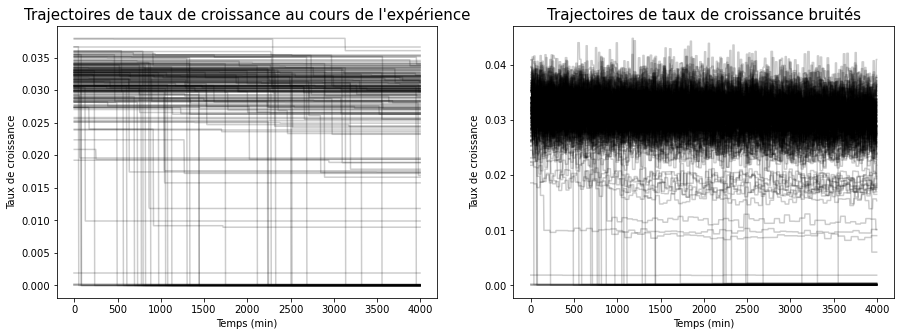

In [90]:
def average_by_generation(growthR, sd_noise=0):
    # Cumulative growth of the cell (exponential coefficient = growth rate x (nbPictures x 4min/picture))
    cum_growth = np.cumsum(growthR*4, axis=0)
    # Total growth at the end of the experiment
    final_growth = cum_growth[-1]
    # The cell divides each time it doubles in size, i.e. every ln(2) increase in growth coefficient
    divisions = np.arange(final_growth//np.log(2)+2)*np.log(2)
    # Generation = interval between between 2 divisions
    generations_masks = [np.logical_and(cum_growth>=divisions[i-1], cum_growth<divisions[i]) for i in range(1,len(divisions))]
    # Length of each generation
    generation_lengths = np.sum(generations_masks, axis=1)
    # Add multiplicative measurement noise (facultative)
    if sd_noise != 0 :
        growthR = growthR*(1+np.random.normal(0, sd_noise, size=np.shape(growthR)))
    # Average the growth rates during each generation
    growthR_genAverage = [np.mean(growthR[generation]) for generation in generations_masks]
    return (np.repeat(growthR_genAverage, repeats=generation_lengths))

def sim_B_growth (growthR_init, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=np.random.randint(10000)):
    """Simule des expériences de croissance bactérienne

    Parameters:
    growthR_init (array): taux de croissance initiaux (pour chaque microcanal)
    dty_mix (tuple): mélange de densités représentant la DFE
    dty_weights (tuple): poids de chacune des densités
    mut_shape (tuple): forme du tableau des taux de croissance en sortie (nombre de mesures x nombre de canaux)
    sd_noise (float): écart-type du bruit Gaussien sur les mesures
    constant_mut_rate (bool): si Vrai le taux de mutation est constant, sinon il dépend du taux de croissance
    mutation_rate (float): taux de mutation
    seed (float): graîne pour les générateurs aléatoires 

    Returns:
    int:Returning value

   """
    
    np.random.seed(seed)
    
    # DFE
    s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=dty_weights, size=mut_shape), choices = dty_mix)

    # Effets relatifs des mutations sur la fitness
    fitness_effects = (1 - s)
    
    # Effets relatifs cumulés des mutations
    cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)
    
    # Évolution du taux de croissance, mutation par mutation
    growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))
    
    # Ajout d'un bruit Gaussien
    growthR_steps_sim_noise = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init*(1+np.random.normal(0, sd_noise, size=mut_shape))))
    growthR_steps_sim_noise[growthR_steps_sim_noise<0] = 0
    
    # Durées entre 2 mutations
    if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
        exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
        mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
        exponential_intervals = np.random.exponential(1/mutation_rate_t)
        exponential_intervals[np.isinf(exponential_intervals)] = exp_duration

    # Temps d'apparition de chaque mutation
    mutation_time = np.cumsum(exponential_intervals, axis=0)

    # Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
    assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[-1,mutation_time[-1,:]<exp_duration])
    
    # Évolution du taux de croissance au cours du temps
    growthR_sim = []
    for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
        # Identifier après quelle mutation la mesure est faite
        cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
        # Prendre la valeur de taux de croissance associé à cette mutation
        growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))

    growthR_sim = np.array(growthR_sim).T
    growthR_sim_noise = np.array([average_by_generation(growthR, sd_noise) for growthR in growthR_sim.T]).T
    
    return ([growthR_sim, growthR_sim_noise])


# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
dty_weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité

im, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time, growthR_sim[:,:200], color="black", alpha=0.2)
ax[0].set_title("Trajectoires de taux de croissance au cours de l'expérience",fontsize=15)
ax[0].set(xlabel="Temps (min)", ylabel="Taux de croissance")

ax[1].plot(time, growthR_sim_noise[:,:200], color="black", alpha=0.2)
ax[1].set_title("Trajectoires de taux de croissance bruités",fontsize=15)
ax[1].set(xlabel="Temps (min)", ylabel="Taux de croissance")
plt.show()

In [91]:
replicates = [sim_B_growth(growthR_init, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(10)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

<ipython-input-90-283c377cfc20>:60: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


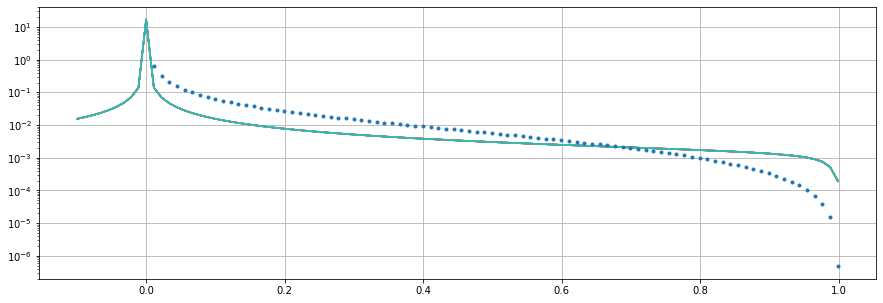

In [134]:
im, ax = plt.subplots(1,1, figsize=(15,5))

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=1,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.abs(dfe))

ax.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,'.')
plt.show()

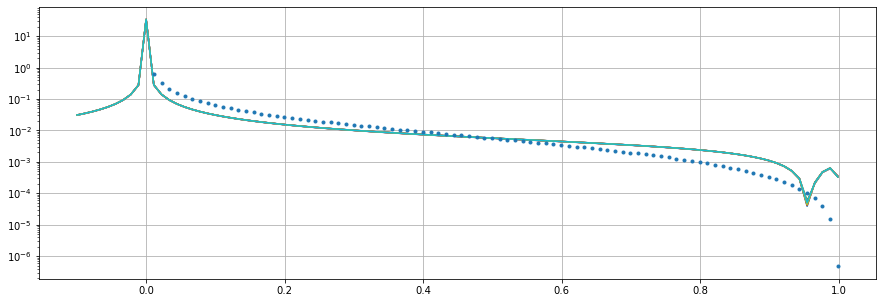

In [133]:
im, ax = plt.subplots(1,1, figsize=(15,5))

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=2,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.abs(dfe))

ax.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,'.')
plt.show()

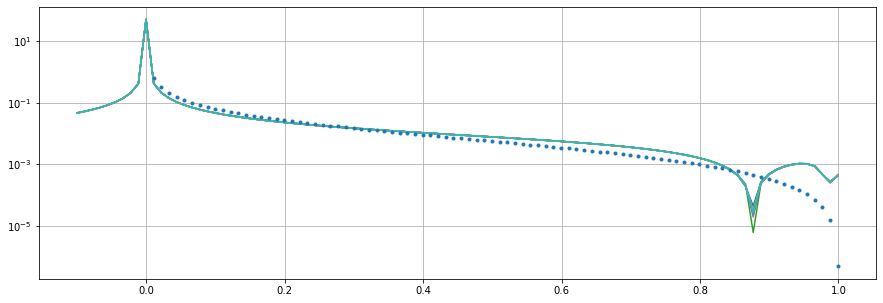

In [132]:
im, ax = plt.subplots(1,1, figsize=(15,5))


for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=3,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.abs(dfe))

ax.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,'.')
plt.show()

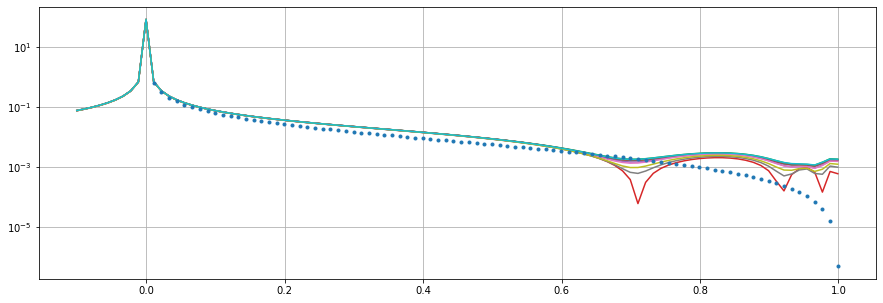

In [131]:
im, ax = plt.subplots(1,1, figsize=(15,5))


for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=5,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.abs(dfe))

ax.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,'.')
plt.show()

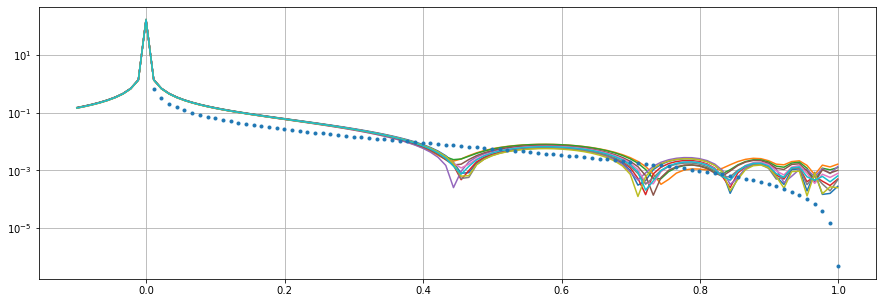

In [130]:
im, ax = plt.subplots(1,1, figsize=(15,5))

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=10,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.abs(dfe))

ax.grid()
plt.yscale('log')
plt.plot(x,dfe_reelle_sim,".")
plt.show()

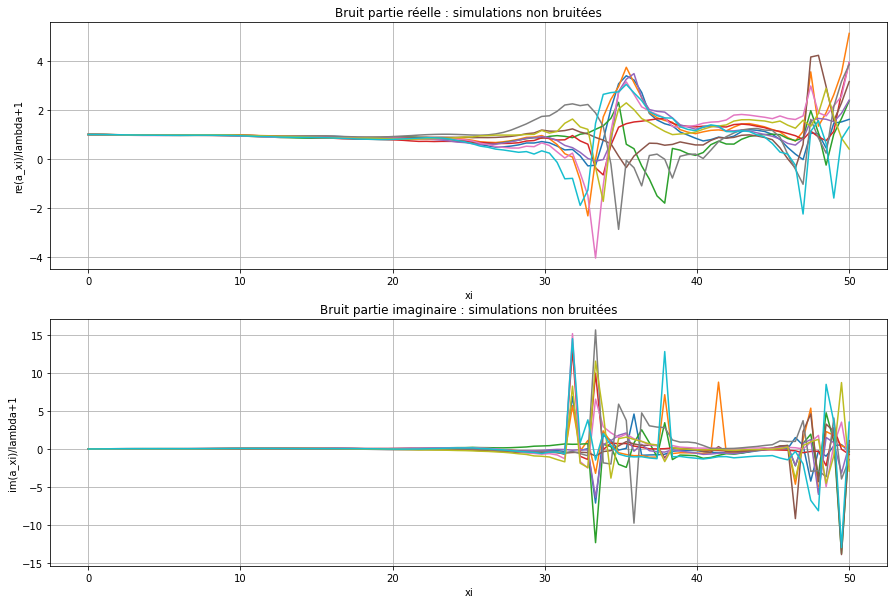

In [96]:
ximin=0
ximax=50
nbreaks_xi=100

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_i in growthR_sim_replicates:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations non bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations non bruitées")
plt.show()

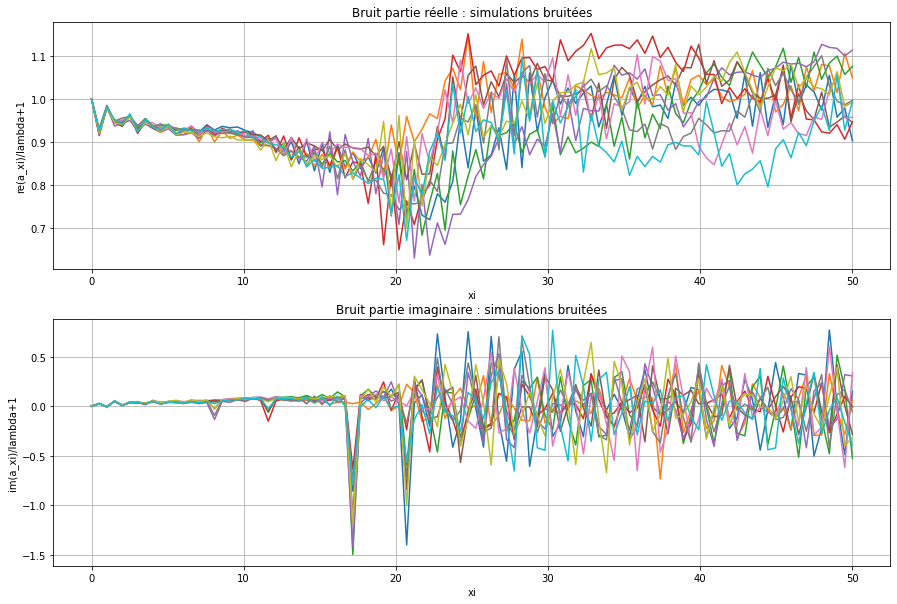

In [97]:
ximin=0
ximax=50
nbreaks_xi=100

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=500)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations bruitées")
plt.show()

Zoom sur $[0,5]$:

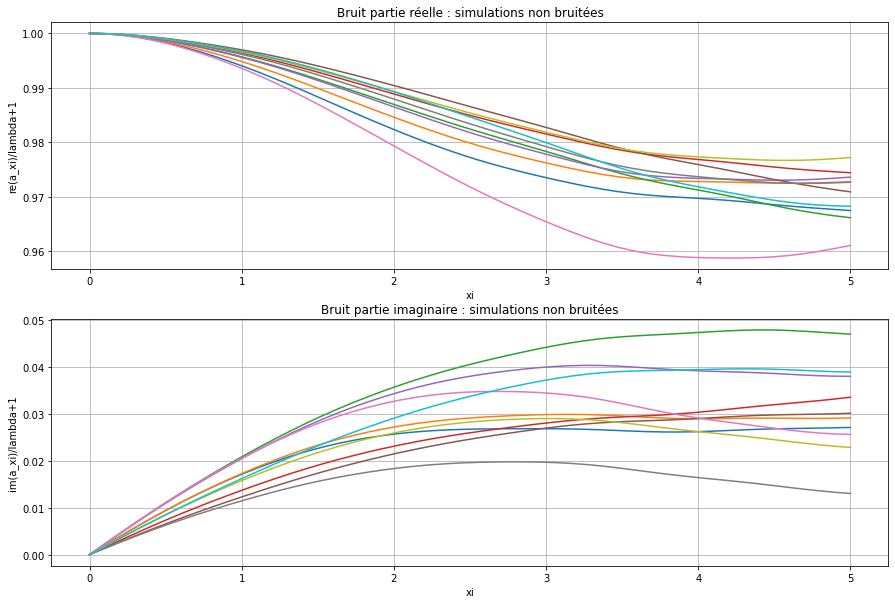

In [98]:
ximin=0
ximax=5
nbreaks_xi=50

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_i in growthR_sim_replicates:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations non bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations non bruitées")
plt.show()

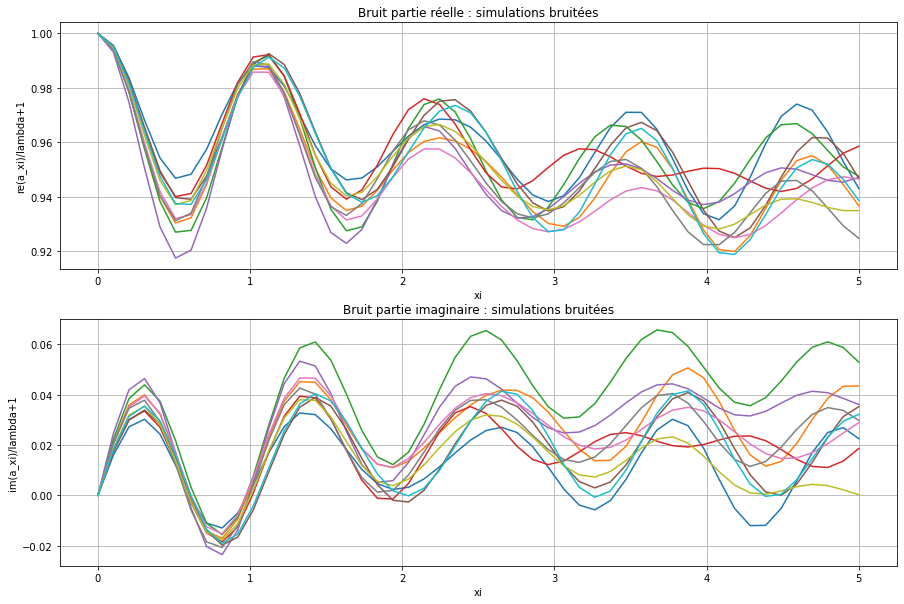

In [99]:
ximin=0
ximax=5
nbreaks_xi=50

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations bruitées")
plt.show()

$\to$ il y a toujours du bruit, mais qui semble plus facile à gérer (par exemple, en comparant à la médiane).

# Distance $L^1$ entre fonctions de répartition

Calcul de la distance $L^1$ entre les fonctions de répartitions correspondant aux densités dist1 et dist2 :


In [122]:
def cdf_l1(dist1,dist2,corr,tronc):
    tronc1,tronc2=tronc
    cdf1=np.cumsum(dist1[1+tronc1:tronc2])
    cdf2=np.cumsum(dist2[1+tronc1:tronc2])
    if(len(cdf1)!=len(cdf2)):
        print("Attention: longueurs différentes",len(cdf1),len(cdf2))
    return np.sum([np.abs(corr*cdf1[i]-cdf2[i]) for i in range(len(cdf1))])*(xmax_reel-xmin_reel)/len(x)

Test avec la distribution beta de l'article et les simulations correspondantes :

DFE estimées :

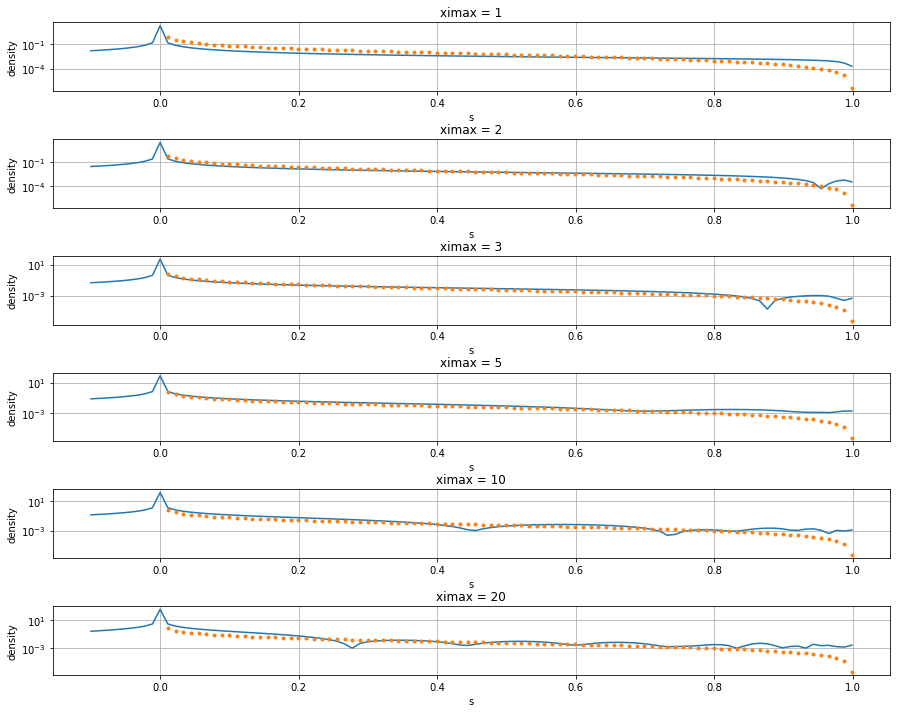

In [118]:
fig, ax = plt.subplots(6,1, figsize=(15,12))
fig.subplots_adjust(hspace=0.7)
dfeln=[]
dfe=[]
for i,ximax in enumerate([1,2,3,5,10,20]):
    dfeln+=[get_dfe(growthR_sim_noise,ximin=0,ximax=ximax,nbreaks_xi=100)]
    dfe+=[[dfeln[i][j]/x[j] for j in range(len(x))]]
    ax[i].plot(x,np.abs(dfe[i]))
    ax[i].grid()
    ax[i].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    ax[i].plot(x,dfe_reelle_sim,".")

plt.show()

DFE originale :


Distance entre ces distributions :

In [129]:
ndfe_real=cdf_l1([0]*100,dfe_reelle_sim,corr=1,tronc=(20,90))
print("Norme tronquée de la vraie DFE :",ndfe_real)
for i in range(6):
    print("Distance tronquée entre la ",i+1,"e DFE estimée et la vraie DFE :",cdf_l1(dfe[i],dfe_reelle_sim,corr=1,tronc=(20,90)))

# NB: terme corr: correction pour que les dfe comparées aient à peu près la même échelle.
# tronc: on tronque le début car on ne repère pas le gros pic très fin passe mal à la discrétisation

Norme tronquée de la vraie DFE : 0.39746431821055933
Distance tronquée entre la  1 e DFE estimée et la vraie DFE : 0.26877495860661954
Distance tronquée entre la  2 e DFE estimée et la vraie DFE : 0.18570890669270085
Distance tronquée entre la  3 e DFE estimée et la vraie DFE : 0.1899519020352248
Distance tronquée entre la  4 e DFE estimée et la vraie DFE : 0.40589794662273027
Distance tronquée entre la  5 e DFE estimée et la vraie DFE : 0.6422857926151316
Distance tronquée entre la  6 e DFE estimée et la vraie DFE : 0.8146912404686195
